In [ ]:
!pip install pycryptodome

In [5]:
import resspect
import pandas as pd
from resspect import request_fastdb_hot_transients
from resspect import fit_TOM
from resspect import submit_queries_to_fastdb
from resspect import time_domain_loop
from resspect.fastdb_client import FASTDBClient
from resspect import time_domain_loop
import os
import re
import numpy as np
import glob
from datetime import datetime, timezone
import json
from astropy.time import Time
import shutil

with open('/Users/arw/secrets/tom2') as ifp:
    fastdb_password = ifp.readline().strip()

#import update_pool_stash
#import astrodash

In [7]:
def get_lc(username, password=None, objectid=None, mjd_now=None):
    # get photometry for one obj up to a specified MJD
    fastdb = FASTDBClient(url = "https://fastdb-resspect-test.lbl.gov", username = username, password = password)
    dic = {}
    if objectid is None and mjd_now is None: 
        raise ValueError("Object ID or MJD not specified") 

    dic['mjd_now']=mjd_now

    res = fastdb.post( f'ltcv/getltcv/{objectid}', json=dic )

    assert res['status'] == "ok"
    #get back dictionary with three keys: status, objinfo (try printing this out), ltcv (dictionary of lists; the keys of the ltcv 
    #dictionary are: 
    # Fields:
         # mjd : float
         # band : str
         # flux : float nJsky
         # fluxerr : float
         # isdet : bool (True if this is detected, false otherwise)
         # ispatch : bool (True if this is detected but had no forced photometry, false otherwise;
         #                 this field is only present if which='patch'.))
    return res['diaobject']

In [4]:
def run_query( tomclient, query, subdict=None ):
    sendjson = { 'query': query }
    if subdict is not None:
        sendjson['subdict'] = subdict
    result = tomclient.post( 'db/runsqlquery/', json=sendjson )
    if ( result.status_code != 200 ):
        raise RuntimeError( f"Got http status {result.status_code}" )
    data = json.loads( result.text )
    if ( 'status' in data ) and ( data['status'] == 'error' ):
        sys.stderr.write( f"ERROR: {data['error']}" )
        return []
    elif ( 'status' not in data ) or ( data['status'] != 'ok' ):
        raise RuntimeError( f"Got unexpected response: {data}" )
    return data['rows']


In [5]:
#pulls recommended spec by resspect from the fastdb
def which_spec(username, password=None, requested_since=None, no_spectra_in_last_days=0):
    fastdb = FASTDBClient(url = "https://fastdb-resspect-test.lbl.gov", username = username, password = password)
    dic = {}
    if requested_since is not None:
        dic['requested_since'] = requested_since

    dic['no_spectra_in_last_days']=no_spectra_in_last_days

    res = fastdb.post( 'spectrum/spectrawanted', json=dic )
    print(res)
    assert res['status'] == "ok"
    return res

In [6]:
#!!!!! this is going to be replaced wiht a web end point - won't use sql query any more
def get_phot(obj_df):
    # get all of the photometry at once
    ids = obj_df['diaobject_id'].tolist()
    res = tom.post('db/runsqlquery/',
                          json={ 'query': 'SELECT diaobject_id, filtername, midpointtai, psflux, psfluxerr'  
                                ' FROM elasticc2_ppdbdiaforcedsource' 
                              ' WHERE diaobject_id IN (%s) ORDER BY diaobject_id, filtername, midpointtai;' % (', '.join(str(id) for id in ids)),
                                'subdict': {} } )
    all_phot = res.json()['rows']
    all_phot_df = pd.DataFrame(all_phot)
    # if you need mag from the arbitrary flux
    # all_phot_df['mag'] = -2.5*np.log10(all_phot_df['psflux']) + 27.5
    # all_phot_df['magerr'] = 2.5/np.log(10) * all_phot_df['psfluxerr']/all_phot_df['psflux']

    # format into a list of dicts
    data = []
    for idx, obj in obj_df.iterrows():
        phot = all_phot_df[all_phot_df['diaobject_id'] == obj['diaobject_id']]
        
        phot_d = {}
        phot_d['objectid'] = int(obj['diaobject_id'])
        phot_d['sncode'] = int(obj['gentype'])
        phot_d['redshift'] = obj['zcmb']
        phot_d['ra'] = obj['ra']
        phot_d['dec'] = obj['dec']
        phot_d['photometry'] = phot[['filtername', 'midpointtai', 'psflux', 'psfluxerr']].to_dict(orient='list')

        phot_d['photometry']['band'] = phot_d['photometry']['filtername']
        phot_d['photometry']['mjd'] = phot_d['photometry']['midpointtai']
        phot_d['photometry']['flux'] = phot_d['photometry']['psflux']
        phot_d['photometry']['fluxerr'] = phot_d['photometry']['psfluxerr']
        del phot_d['photometry']['filtername']
        del phot_d['photometry']['midpointtai']
        del phot_d['photometry']['psflux']
        del phot_d['photometry']['psfluxerr']
        
        data.append(phot_d)

    return data

In [23]:
def update_training(day: str, classified_objs: list):
    outdir = 'TOM_days_storage'
    training_set_path = outdir+'/TOM_training_features_stash'

    # Update old objects:
    # Get all object ids. Check if object ids are in hot_transients (this only works if we look at transients in the past 1 day)
    # if it is, add these features with everything else the same
    # Q: will it complain that there are multiple of the same object id in the same training file?
    with open(training_set_path, 'r') as f:
        training_set = f.readlines()

    training_ids = []
    store_old = []
    
    for line in training_set:
        
        a_id = line.split(',')[0]
        #get list of ids
        if a_id not in training_ids:
            store_old.append(line.split(','))
            training_ids.append(a_id)
        
    training_ids.pop(0)
    store_old.pop(0)


    #read in previous nights hot transients

    hot_transients_path = outdir+f'/TOM_hot_features_day_{day}.csv'

    with open(hot_transients_path, 'r') as f:
        hot_transients = f.readlines()
    
    store_new = []
    store_new_ids = []
    
    for line in hot_transients:
        if line.startswith(tuple(training_ids)):
            temp = line.split(',')
            store_new.append(temp)
            store_new_ids.append(temp[0])
    
    # need to change these to have the correct redshift, label, code, orig_sample
    # find objects with the same ids
    add_lines = []
    for i, a_id in enumerate(store_new_ids):
        for line in store_old:
            if line[0]==a_id:
                z = line[1]
                label = line[2]
                code = line[3]
                orig_sample = line[4]
                temp = store_new[i]
                temp[1] = z
                temp[2] = label
                temp[3] = code
                temp[4] = orig_sample
                add_lines.append(','.join(temp))
                
    # Now have the lines to add with the correct labels + features. Need to append to file
    with open(training_set_path, "a") as myfile:
        for line in add_lines:
            myfile.write(line)

        
    # Time to add the newly classified objects
    for obj in classified_objs:
        obj_id = obj['objectid']
        try:
            # !!!!! call the end point spectrum/getknownspectruminfo. pass the root diaobjectid in oid
            #will get back dictionary of lists. keywords: (no peakmjd) z, classid
            #get classified objects in the past x days - file issue in fastdb
            #to use this I will have to write code that uploads the info to fastdb
            res = tom.post('db/runsqlquery/',
                                    json={ 'query': 'SELECT diaobject_id, gentype, zcmb, peakmjd,' 
                                          f' peakmag_g, ra, dec FROM elasticc2_diaobjecttruth WHERE diaobject_id={obj_id};', 
                                         'subdict': {}} )
            tom_obj = res.json()['rows']
            obj_phot = get_phot(pd.DataFrame(tom_obj))

            photometry = obj_phot[0]['photometry']

            # Filter entries where mjd <= certain mjd
            filtered = [
                (b, m, f, e)
                for b, m, f, e in zip(photometry['band'], photometry['mjd'], photometry['flux'], photometry['fluxerr'])
                if m <= 60797+day
            ]
            
            # Unpack the filtered data back into the dictionary
            if filtered:
                photometry['band'], photometry['mjd'], photometry['flux'], photometry['fluxerr'] = map(list, zip(*filtered))
            else:
                raise ExceptionType("Error Message")
            
            # Check result
            obj_phot[0]['photometry'] = photometry

            
            fit_TOM(obj_phot, output_features_file = outdir+'/to_concat', feature_extractor = 'malanchev')
        except:
            print('ALERT: cannot pull id: ',obj_id)
            #print(obj_phot)
        
        #this wrote to file 'to_concat' need to read this in and concatenate obj to training_set_path
        
        concat_path = outdir+'/to_concat'
        with open(concat_path, 'r') as f:
            concat_obj = f.readlines()
        concat_obj = concat_obj[1].split(',')
        
        # need to change these to have the correct redshift, label, code, orig_sample
        z = str(obj['z'])
        if obj['classid'] == 2222:
            type = 'Ia'
        else:
            type = 'other'
        #❗️ not sure if this is the right code
        code = str(obj['classid'])
        orig_sample = 'train'

        
        concat_obj[1] = z
        concat_obj[2] = type
        concat_obj[3] = code
        concat_obj[4] = orig_sample

        #rejoin obj
        line = ','.join(concat_obj)
        
        with open(training_set_path, "a") as myfile:
            myfile.write(line)
        

#❗️ would like to write some tests for this
        


# Create test/train/val

In [8]:
#MAKE INITIAL TRAINING SET 
objs = []

tom = TomClient(url = "https://desc-tom-2.lbl.gov", username = 'amandaw8', passwordfile = '/Users/arw/secrets/tom2')

res = tom.post('db/runsqlquery/',
                        json={ 'query': 'SELECT diaobject_id, gentype, zcmb, peakmjd,' 
                              ' peakmag_g, ra, dec FROM elasticc2_diaobjecttruth WHERE peakmjd>61300 and peakmjd<61309 and gentype=10 limit 10;', 
                             'subdict': {}} )
objs.extend(res.json()['rows'])

#ELASTICC2_FINAL_SNII+HostXT_V19
res = tom.post('db/runsqlquery/',
                        json={ 'query': 'SELECT diaobject_id, gentype, zcmb, peakmjd,' 
                              ' peakmag_g, ra, dec FROM elasticc2_diaobjecttruth WHERE peakmjd>61300 and peakmjd<61309 and gentype=21 limit 5;', 
                             'subdict': {}} )
objs.extend(res.json()['rows'])

#ELASTICC2_FINAL_SNII-Templates
res = tom.post('db/runsqlquery/',
                        json={ 'query': 'SELECT diaobject_id, gentype, zcmb, peakmjd,' 
                              ' peakmag_g, ra, dec FROM elasticc2_diaobjecttruth WHERE peakmjd>61300 and peakmjd<61309 and gentype=31 limit 5;', 
                             'subdict': {}} )
objs.extend(res.json()['rows'])

training_objs = get_phot(pd.DataFrame(objs))
outdir = 'TOM_days_storage'

if not os.path.exists(outdir):
    os.makedirs(outdir)


fit_TOM(training_objs, output_features_file = outdir+'/TOM_training_features_stash', feature_extractor = 'malanchev')
data = pd.read_csv('TOM_days_storage/TOM_training_features_stash',index_col=False)
data['orig_sample'] = 'train'
data["type"] = np.where(data["code"] == 10, 'Ia', 'other')
data.to_csv('TOM_days_storage/TOM_training_features_stash',index=False)

INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/TOM_training_features_stash


In [9]:
#✅ MAKE TEST SET 
objs = []

tom = TomClient(url = "https://desc-tom-2.lbl.gov", username = 'amandaw8', passwordfile = '/Users/arw/secrets/tom2')

res = tom.post('db/runsqlquery/',
                        json={ 'query': 'SELECT diaobject_id, gentype, zcmb, peakmjd,' 
                              ' peakmag_g, ra, dec FROM elasticc2_diaobjecttruth WHERE peakmjd>61310 and peakmjd<61339 and gentype=10 limit 1000;', 
                             'subdict': {}} )
objs.extend(res.json()['rows'])

#ELASTICC2_FINAL_SNII+HostXT_V19
res = tom.post('db/runsqlquery/',
                        json={ 'query': 'SELECT diaobject_id, gentype, zcmb, peakmjd,' 
                              ' peakmag_g, ra, dec FROM elasticc2_diaobjecttruth WHERE peakmjd>61310 and peakmjd<61339 and gentype=21 limit 500;', 
                             'subdict': {}} )
objs.extend(res.json()['rows'])

#ELASTICC2_FINAL_SNII-Templates
res = tom.post('db/runsqlquery/',
                        json={ 'query': 'SELECT diaobject_id, gentype, zcmb, peakmjd,' 
                              ' peakmag_g, ra, dec FROM elasticc2_diaobjecttruth WHERE peakmjd>61310 and peakmjd<61339 and gentype=31 limit 500;', 
                             'subdict': {}} )
objs.extend(res.json()['rows'])

test_objs = get_phot(pd.DataFrame(objs))
outdir = 'TOM_days_storage'

if not os.path.exists(outdir):
    os.makedirs(outdir)


fit_TOM(test_objs, output_features_file = outdir+'/TOM_test_features_stash', feature_extractor = 'malanchev')
data = pd.read_csv('TOM_days_storage/TOM_test_features_stash',index_col=False)
data['orig_sample'] = 'test'
data["type"] = np.where(data["code"] == 10, 'Ia', 'other')
data.to_csv('TOM_days_storage/TOM_test_features_stash',index=False)


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/TOM_test_features_stash


In [10]:
#✅ MAKE VALIDATION SET 
objs = []

tom = TomClient(url = "https://desc-tom-2.lbl.gov", username = 'amandaw8', passwordfile = '/Users/arw/secrets/tom2')

res = tom.post('db/runsqlquery/',
                        json={ 'query': 'SELECT diaobject_id, gentype, zcmb, peakmjd,' 
                              ' peakmag_g, ra, dec FROM elasticc2_diaobjecttruth WHERE peakmjd>61340 and gentype=10 limit 1000;', 
                             'subdict': {}} )
objs.extend(res.json()['rows'])

#ELASTICC2_FINAL_SNII+HostXT_V19
res = tom.post('db/runsqlquery/',
                        json={ 'query': 'SELECT diaobject_id, gentype, zcmb, peakmjd,' 
                              ' peakmag_g, ra, dec FROM elasticc2_diaobjecttruth WHERE peakmjd>61340 and gentype=21 limit 500;', 
                             'subdict': {}} )
objs.extend(res.json()['rows'])

#ELASTICC2_FINAL_SNII-Templates
res = tom.post('db/runsqlquery/',
                        json={ 'query': 'SELECT diaobject_id, gentype, zcmb, peakmjd,' 
                              ' peakmag_g, ra, dec FROM elasticc2_diaobjecttruth WHERE peakmjd>61340 and gentype=31 limit 500;', 
                             'subdict': {}} )
objs.extend(res.json()['rows'])

val_objs = get_phot(pd.DataFrame(objs))
outdir = 'TOM_days_storage'

if not os.path.exists(outdir):
    os.makedirs(outdir)


fit_TOM(val_objs, output_features_file = outdir+'/TOM_validation_features_stash', feature_extractor = 'malanchev')
data = pd.read_csv('TOM_days_storage/TOM_validation_features_stash',index_col=False)
data['orig_sample'] = 'validation'
data["type"] = np.where(data["code"] == 10, 'Ia', 'other')
data.to_csv('TOM_days_storage/TOM_validation_features_stash',index=False)

INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/TOM_validation_features_stash


In [11]:
def recommend(sim: bool=True, day: int=-99):
                            #🔲 check for new spec+classification for training set before running the loop
    #✅flag for simulated vs real data
                            #🔲implement an auto-check
    #✅first thing, check if it's real or sim data
                            #🔲MAKE CLEAR WHAT IS FOR REAL DATA VS SIM (eg. real data will want date)
    #✅request light curve data from the TOM - for real and simulated

    outdir = 'TOM_days_storage'
    file_name = outdir+'/TOM_hot_features_day_'+str(day)+'.csv'
    yesterday_file = outdir+'/TOM_hot_features_day_'+str(day-1)+'.csv'

    #!!!!! new function request_fastdb_data
    data_dic = request_fastdb_hot_transients(username='amandaw8',
                                passwordfile=fastdb_password,detected_in_last_days = 1, mjdnow = 60797+day)#, 
                                #cheat_gentypes = [82, 10, 21, 27, 26, 37, 32, 36, 31, 89])
    data_dic=data_dic['diaobject']
    if len(data_dic)==0:
        print('no observations tonight')
        
        # create tom hot features empty file
        # with open(file_name, "w") as file:
        #     file.write(empty_text)
        shutil.copyfile(yesterday_file, file_name)
        # ‼️ maybe do this differently. instead of skipping choose from previous night
        return('empty')
       
    
    #✅run that data through RESSPECT to get features
                            #🔲at some point, cut out objects that are not likely SN - do this before it gets to RESSPECT probably
    #✅clarify out file argument/data base
#    if day >= 0:
#        file_name = outdir+'/TOM_hot_features_day_'+str(day)+'.csv'
#    else:
#        file_name = outdir+'/TOM_hot_features.csv'
    #!!!!! change to fastdb    
    fit_TOM(data_dic, output_features_file = file_name, feature_extractor = 'malanchev')
    data = pd.read_csv(file_name, index_col=False)
    data['orig_sample'] = 'pool'
    #add date added so that we can remove when they are too old
    
    data.to_csv(file_name,index=False)
    
    #✅update feature lists
    #✅ change this so that we have a new file for each day - just make it so that update_pool_stash writes to a new file 
    #✅(and puts this file in a directory)
                            #🔲 Probably want to make this more general file names down the line.....
#    update_pool_stash(day)
    
    #🔲run the loop to get queried objects and updated metrics
    days = [day-1, day+1]                                # first and last day of the survey
    training = None                           # if int take int number of objs
                                                        # for initial training, 50% being Ia
    
    strategy = 'UncSampling'                        # learning strategy
    batch = 11                                       # if int, ignore cost per observation,
    #                                                     # if None find optimal batch size
    
    sep_files = True                               # if True, expects train, test and
                                                        # validation samples in separate filess
    
    path_to_features_dir = 'TOM_days_storage/'   # folder where the files for each day are stored
    
    # output results for metrics
    ######🔲 need to make sure this appends each day instead of rewriting
    output_metrics_file = 'results/metrics_' + strategy + '_' + str('ini_train_set') + \
                           '_batch' + str(batch) +  '.csv'
    
    # output query sample
    output_query_file = 'results/queried_' + strategy + '_' + str('ini_train_set') + \
                            '_batch' + str(batch) + '_day_'+ str(day) + '.csv'
    
    path_to_ini_files = {}
    
    # features from full light curves for initial training sample
    path_to_ini_files['train'] = 'TOM_days_storage/TOM_training_features_stash'
    path_to_ini_files['test'] = 'TOM_days_storage/TOM_test_features_stash'
    path_to_ini_files['validation'] = 'TOM_days_storage/TOM_validation_features_stash'
    
    survey='LSST'
    
    classifier = 'RandomForest'
    n_estimators = 1000                             # number of trees in the forest
    
    feature_extraction_method = 'malanchev'
    screen = False                                  # if True will print many things for debuging
    fname_pattern = ['TOM_hot_features_day_', '.csv']                # pattern on filename where different days
                                                        # are stored
    
    queryable= False                                 # if True, check brightness before considering
                                                        # an object queryable
    
    #budgets = (6. * 3600, 6. * 3600)        # budget of 6 hours per night of observation
    
    
    # run time domain loop
    time_domain_loop(days=days, output_metrics_file=output_metrics_file,
                     output_queried_file=output_query_file,
                     path_to_ini_files=path_to_ini_files,
                     path_to_features_dir=path_to_features_dir,
                     strategy=strategy, fname_pattern=fname_pattern, batch=batch,
                     classifier=classifier,
                     sep_files=sep_files, #budgets=budgets,
                     screen=screen, #initial_training=training,
                     survey=survey, queryable=queryable, n_estimators=n_estimators,
                     feature_extraction_method=feature_extraction_method)
    #🔲 do we want higher entropy in our returned objects?
    #✅ Read in RESSPECT requests to input to TOM format
    ids = list(pd.read_csv(output_query_file)['id'])
    ids = [int(id) for id in ids]
    num = int(len(ids)/5)
    mod = len(ids)%5
    num_list = [num]*5
    mod_list = []
    for i in range(mod):
        mod_list.append(1)
    rem = 5-len(mod_list)
    mod_list = mod_list+[0]*rem
    num_list=list(np.asarray(num_list)+mod_list)
    priorities = []
    priorities.append([1]*num_list[0]+[2]*num_list[1]+[3]*num_list[2]+[4]*num_list[3]+[5]*num_list[4])    
    priorities = priorities[0]

    print(ids, priorities)

    
    
    #✅ send these queried objects to the TOM
    #🔲 do we at some point want to delete requests after x number of days
    submit_queries_to_fastdb('amandaw8', fastdb_password, objectids = ids, priorities = priorities, requester = 'resspect')

    return ids, priorities

In [12]:
def get_ids(reqs):
    reqs = reqs['wantedspectra']
    ids = []
    for obj in reqs:
        ids.append(obj['oid'])
    return ids

In [13]:
# !!!!! this doesn't exist. figure this out later
def get_true_label(objid, tomclient, subdict=None):
    tom = TomClient(url = "https://desc-tom-2.lbl.gov", username = 'amandaw8', passwordfile = '../../secrets/TOM2')

    data=run_query(tom, f'SELECT gentype FROM elasticc2_diaobjecttruth WHERE diaobject_id = {objid}')
    return data[0]['gentype']

In [14]:
def observe(time, ids=None):
    if ids is None:
        reqs = which_spec('amandaw8', password=fastdb_password, requested_since = time,  no_spectra_in_last_days=0) #UTC
        ids = get_ids(reqs)
    print(ids)
    id_list = []
    Ia_type_list = []
    sn_type_list = []
    taxonomy_list = []
    mjd_list = []
    taxonomy_dic = {10:'2222', 
                    30:'2224',31:'2224',32:'2224',35:'2224',36:'2224',37:'2224',
                    20:'2223',21:'2223',25:'2223',26:'2223',27:'2223',
                    82:'2233',
                    89:'2235'}
    for a_id in ids:
        # file = f'astrodash_spec_storage/Contaminated_RESSPECT/output_bank/DASH_matches_{a_id}.txt'
        try:
            # !!!!! replace this line wiht a function that gets the obj id and looks it up in the snana truth file
            sn_type = get_true_label(a_id,tom)#get_id_type_from_dash(file)
            if sn_type == 10:
                Ia_type = 'Ia'
            else:
                Ia_type = 'other'
            
            id_list.append(a_id)
            Ia_type_list.append(Ia_type)
            sn_type_list.append(sn_type)
            taxonomy_list.append(taxonomy_dic[sn_type])
            now = Time.now().mjd
            mjd_list.append(now)
        except:
            continue
    return id_list, Ia_type_list, sn_type_list, taxonomy_list, mjd_list
        


In [15]:
# send back to the TOM
def send_class_to_fastdb(username, password=None, objectid=-9,
                      facility='', mjd=-9, z='', classid=-9):
    fastdb = FASTDBClient(url = "https://fastdb-resspect-test.lbl.gov", username = username, password = password)
    dic = {}
    
    dic['objectid'] = objectid # !!!!! figure out root id vs obj id
    dic['facility'] = facility
    dic['mjd'] = mjd
    dic['z'] = z
    dic['classid'] = classid

    res = fastdb.post( 'spectrum/reportspectruminfo', json=dic )

    assert res['status'] == "ok"
    return res

In [16]:
def send_classes_to_fastdb(id_list, mjd_list, taxonomy_list):
    for i in range(len(id_list)):
        # !!!!! will have a redshift to send if i a pulling from the truth file
        send_class_to_fastdb('amandaw8', password = fastdb_password, objectid = id_list[i], 
                          facility = 'truth', mjd = mjd_list[i], z = '', classid = taxonomy_list[i])


In [17]:
def get_classes(time):
        
    fastdb = TomClient(url = "https://fastdb-resspect-test.lbl.gov/", username = 'amandaw8', password = fastdb_password)
    #!!!!! since still needs to be updated. there's an issue number 61 in the fastdb github
    res = tom.post( 'elasticc2/getknownspectruminfo', json={'since':time} )
    
    assert res['status'] == "ok"
    return( res['spectra'])

In [38]:
empty_count = 0
for day in range(319,366):
    utc_now = datetime.now(timezone.utc)
    time = str(utc_now).split('.')[0]
    is_empty = recommend(day = day)
    if not is_empty == 'empty':
        id_list, Ia_type_list, sn_type_list, taxonomy_list, mjd_list = observe(time, is_empty[0])
        send_classes_to_TOM(id_list, mjd_list, taxonomy_list)
        classified_obj = get_classes(time)
        update_training(day, classified_obj)
    else:
        empty_count += 1
        


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/TOM_hot_features_day_319.csv
100% (1 of 1) |##########################| Elapsed Time: 0:01:13 Time:  0:01:13


[145526142, 124587554, 30870438, 81208770, 20558222, 35501538, 149414992, 66250341, 84583751, 120218220] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[145526142, 124587554, 30870438, 81208770, 20558222, 35501538, 149414992, 66250341, 84583751, 120218220]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[150380316, 64899788, 128635946, 149587988, 158977380, 129013685, 101972375, 58491849, 26244372, 123677811] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[150380316, 64899788, 128635946, 149587988, 158977380, 129013685, 101972375, 58491849, 26244372, 123677811]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[142984826, 118176192, 70912422, 53321089, 53719876, 37121268, 43384619, 15665935, 60176486, 139314630] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[142984826, 118176192, 70912422, 53321089, 53719876, 37121268, 43384619, 15665935, 60176486, 139314630]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[38035955, 58948906, 21065634, 5206484, 51405412, 62650483, 25742233, 93991480, 54130268, 156227178] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[38035955, 58948906, 21065634, 5206484, 51405412, 62650483, 25742233, 93991480, 54130268, 156227178]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[3901483, 142348154, 82215781, 142070864, 77297647, 14606550, 136168138, 158424502, 130116494, 87736923] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[3901483, 142348154, 82215781, 142070864, 77297647, 14606550, 136168138, 158424502, 130116494, 87736923]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat


ALERT: cannot pull id:  87736923


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/TOM_hot_features_day_324.csv
100% (1 of 1) |##########################| Elapsed Time: 0:01:16 Time:  0:01:16


[27509474, 109962049, 113142430, 27802979, 20652667, 74859149, 72142306, 40122162, 114624812, 28067761] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[27509474, 109962049, 113142430, 27802979, 20652667, 74859149, 72142306, 40122162, 114624812, 28067761]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[83523452, 21349601, 51925007, 100722110, 55483212, 119501006, 139552297, 136941784, 131560128, 38941740] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[83523452, 21349601, 51925007, 100722110, 55483212, 119501006, 139552297, 136941784, 131560128, 38941740]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[36879899, 65547897, 55177998, 11667514, 78079196, 92298481, 11382150, 55565241, 157176425, 75072759] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[36879899, 65547897, 55177998, 11667514, 78079196, 92298481, 11382150, 55565241, 157176425, 75072759]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[23062234, 145795560, 95683730, 18679535, 137092811, 145794641, 125458559, 35126471, 73214147, 72330541] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[23062234, 145795560, 95683730, 18679535, 137092811, 145794641, 125458559, 35126471, 73214147, 72330541]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[62563989, 59002951, 25323179, 28769592, 131536376, 66507782, 45421429, 74932041, 59669413, 85408522] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[62563989, 59002951, 25323179, 28769592, 131536376, 66507782, 45421429, 74932041, 59669413, 85408522]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[40760836, 31952939, 145326481, 135741616, 93709300, 146162654, 83431548, 45184033, 141206102, 84544802] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[40760836, 31952939, 145326481, 135741616, 93709300, 146162654, 83431548, 45184033, 141206102, 84544802]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[117923548, 141516949, 105225469, 56388122, 116388122, 149460612, 91719304, 118939592, 41973960, 21786912] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[117923548, 141516949, 105225469, 56388122, 116388122, 149460612, 91719304, 118939592, 41973960, 21786912]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[51711184, 47643879, 152195290, 51990722, 74435866, 26006953, 54768215, 73503750, 39762760, 131256344] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[51711184, 47643879, 152195290, 51990722, 74435866, 26006953, 54768215, 73503750, 39762760, 131256344]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[141206883, 46814746, 74682821, 92250869, 118907964, 69386278, 150593581, 129865522, 3437307, 55728204] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[141206883, 46814746, 74682821, 92250869, 118907964, 69386278, 150593581, 129865522, 3437307, 55728204]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[69988405, 145364516, 12008183, 9515305, 46274411, 9603075, 87460463, 92318139, 89840617, 9954071] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[69988405, 145364516, 12008183, 9515305, 46274411, 9603075, 87460463, 92318139, 89840617, 9954071]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[156432690, 81926131, 139654090, 110934670, 14045738, 8546160, 149153211, 37514134, 99533226, 72339773] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[156432690, 81926131, 139654090, 110934670, 14045738, 8546160, 149153211, 37514134, 99533226, 72339773]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[151389271, 55379907, 123735546, 66052139, 99539851, 82398342, 80834630, 84870841, 66783272, 135482882] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[151389271, 55379907, 123735546, 66052139, 99539851, 82398342, 80834630, 84870841, 66783272, 135482882]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[33562188, 108817385, 111770177, 112899727, 113559276, 152424531, 33568682, 128442264, 147714204, 90982865] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[33562188, 108817385, 111770177, 112899727, 113559276, 152424531, 33568682, 128442264, 147714204, 90982865]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[95745953, 9590569, 72219745, 105688443, 54012401, 10113611, 57068822, 16366546, 108488797, 6281587] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[95745953, 9590569, 72219745, 105688443, 54012401, 10113611, 57068822, 16366546, 108488797, 6281587]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[64551794, 117053417, 53008783, 67680609, 24717503, 28459695, 66296885, 81513303, 92339759, 92296551] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[64551794, 117053417, 53008783, 67680609, 24717503, 28459695, 66296885, 81513303, 92339759, 92296551]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[149347582, 72741734, 132169643, 73149351, 21145379, 148543737, 56732039, 136321929, 32327005, 146632231] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[149347582, 72741734, 132169643, 73149351, 21145379, 148543737, 56732039, 136321929, 32327005, 146632231]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[106874839, 49455710, 118020891, 41891622, 118920873, 120086643, 87230480, 56601643, 75235142, 104920725] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[106874839, 49455710, 118020891, 41891622, 118920873, 120086643, 87230480, 56601643, 75235142, 104920725]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[94131671, 11136066, 144767109, 70805387, 99332267, 69727408, 151484507, 108683776, 14671050, 124615715] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[94131671, 11136066, 144767109, 70805387, 99332267, 69727408, 151484507, 108683776, 14671050, 124615715]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[91050637, 75894888, 7564026, 45780481, 104583276, 155148449, 135766442, 152942683, 4914133, 31509532] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[91050637, 75894888, 7564026, 45780481, 104583276, 155148449, 135766442, 152942683, 4914133, 31509532]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[34383304, 75467363, 26205851, 55734911, 55675603, 28382741, 15144273, 137452067, 133851046, 29546974] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[34383304, 75467363, 26205851, 55734911, 55675603, 28382741, 15144273, 137452067, 133851046, 29546974]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[60621657, 13398782, 156611747, 84106960, 37204573, 131748192, 54465200, 28043406, 38226552, 145612438] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[60621657, 13398782, 156611747, 84106960, 37204573, 131748192, 54465200, 28043406, 38226552, 145612438]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[128319390, 157609382, 117253252, 64477266, 63974932, 120119706, 129994059, 90333180, 142582164, 113722902] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[128319390, 157609382, 117253252, 64477266, 63974932, 120119706, 129994059, 90333180, 142582164, 113722902]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[88772283, 74780158, 38609496, 147165983, 43973002, 90705494, 44505927, 136509512, 135081142, 46131694] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[88772283, 74780158, 38609496, 147165983, 43973002, 90705494, 44505927, 136509512, 135081142, 46131694]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[18493251, 139212752, 75881078, 35159026, 52930975, 135763868, 142647897, 53484662, 158377870, 145007534] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[18493251, 139212752, 75881078, 35159026, 52930975, 135763868, 142647897, 53484662, 158377870, 145007534]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[128484807, 48816698, 105514071, 120836786, 128755665, 157654167, 91794233, 11204042, 86852540, 77452044] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[128484807, 48816698, 105514071, 120836786, 128755665, 157654167, 91794233, 11204042, 86852540, 77452044]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[79673267, 26363098, 123687293, 125662643, 44055941, 127852624, 76901825, 93270484, 139150691, 59018008] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[79673267, 26363098, 123687293, 125662643, 44055941, 127852624, 76901825, 93270484, 139150691, 59018008]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[3570486, 81450118, 24563752, 27526669, 70168918, 31173075, 91404427, 80668717, 145049644, 148927237] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[3570486, 81450118, 24563752, 27526669, 70168918, 31173075, 91404427, 80668717, 145049644, 148927237]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[155830192, 36077871, 64783562, 112366203, 40835208, 107133514, 59000617, 84374575, 59081611, 75528465] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[155830192, 36077871, 64783562, 112366203, 40835208, 107133514, 59000617, 84374575, 59081611, 75528465]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[145231535, 98753069, 120755494, 52433030, 12337622, 86235670, 40250780, 8141332, 64353323, 133708894] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[145231535, 98753069, 120755494, 52433030, 12337622, 86235670, 40250780, 8141332, 64353323, 133708894]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[68490699, 82061998, 53250853, 137510945, 72478209, 52771545, 90516313, 54851315, 102174335, 110969150] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[68490699, 82061998, 53250853, 137510945, 72478209, 52771545, 90516313, 54851315, 102174335, 110969150]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[82862957, 8817028, 85879881, 124194781, 43741378, 29121258, 65761204, 81394156, 82393091, 155027386] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[82862957, 8817028, 85879881, 124194781, 43741378, 29121258, 65761204, 81394156, 82393091, 155027386]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[54717095, 147417432, 71592795, 42045865, 74537891, 119430564, 19694571, 111755068, 133229062, 151447581] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[54717095, 147417432, 71592795, 42045865, 74537891, 119430564, 19694571, 111755068, 133229062, 151447581]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[154076993, 96952706, 83261721, 54014361, 158217230, 106634225, 71880679, 45204152, 87006792, 27417504] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[154076993, 96952706, 83261721, 54014361, 158217230, 106634225, 71880679, 45204152, 87006792, 27417504]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[117645414, 109667710, 46300357, 148455741, 4279892, 118816263, 39822247, 133741129, 54045732, 19082057] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[117645414, 109667710, 46300357, 148455741, 4279892, 118816263, 39822247, 133741129, 54045732, 19082057]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[84945561, 17367607, 87347010, 62742619, 152346211, 122127906, 77756124, 1457711, 130959523, 130798233] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[84945561, 17367607, 87347010, 62742619, 152346211, 122127906, 77756124, 1457711, 130959523, 130798233]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[12035265, 132100983, 65674469, 52988310, 90871963, 31264102, 100359834, 54565815, 90710777, 157869745] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[12035265, 132100983, 65674469, 52988310, 90871963, 31264102, 100359834, 54565815, 90710777, 157869745]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[8734896, 121637091, 9225166, 35117308, 134491454, 141505901, 100124785, 144951286, 55176869, 87742336] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[8734896, 121637091, 9225166, 35117308, 134491454, 141505901, 100124785, 144951286, 55176869, 87742336]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[91446419, 83229994, 80010104, 91275280, 33859371, 131154601, 42019867, 13462721, 83499388, 51705275] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[91446419, 83229994, 80010104, 91275280, 33859371, 131154601, 42019867, 13462721, 83499388, 51705275]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[27665988, 58639455, 143166070, 68207036, 153500591, 37513021, 103140742, 23084351, 141717498, 34653298] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[27665988, 58639455, 143166070, 68207036, 153500591, 37513021, 103140742, 23084351, 141717498, 34653298]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[100700317, 54444587, 31528166, 36970633, 156498417, 151977659, 141337035, 26705083, 73913319, 87194765] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[100700317, 54444587, 31528166, 36970633, 156498417, 151977659, 141337035, 26705083, 73913319, 87194765]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[116203138, 70324054, 49420058, 143137416, 48022757, 41371483, 79071329, 7528937, 33614298, 34532518] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[116203138, 70324054, 49420058, 143137416, 48022757, 41371483, 79071329, 7528937, 33614298, 34532518]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

[123889598, 14761073, 93389837, 99447092, 103309370, 157720526, 87637976, 139159379, 146323575, 92563793] [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
[123889598, 14761073, 93389837, 99447092, 103309370, 157720526, 87637976, 139159379, 146323575, 92563793]


INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:root:Features have been saved to: TOM_days_storage/to_concat
INFO:root:Starting TOM malanchev fit...
INFO:r

In [ ]:
empty_count

In [ ]:
#need to write the random code

In [ ]:
data_dic = request_TOM_data(url = "https://desc-tom-2.lbl.gov",username='amandaw8',
                                passwordfile='/Users/arw/secrets/tom2',detected_in_last_days = 1, mjdnow = 60797+105, 
                                cheat_gentypes = [82, 10, 21, 27, 26, 37, 32, 36, 31, 89])

In [ ]:
tom = TomClient(url = "https://desc-tom-2.lbl.gov", username = 'amandaw8', passwordfile = '/Users/arw/secrets/tom2')
res = tom.post( 'elasticc2/getknownspectruminfo', json={'since':'2025-05-15 13:20:00'} )

assert res.status_code == 200
assert res.json()['status'] == "ok"
reqs = res.json()
classified_obj = reqs['spectra']

In [ ]:
classified_obj

In [ ]:
#Check these went through

# send back to the TOM
def check_classified_obj(username, passwordfile=None, password=None, facility='', since=''):
    tom = TomClient(url = "https://desc-tom-2.lbl.gov", username = username, password = password, 
                    passwordfile = passwordfile)
    dic = {}
    
    dic['facility'] = facility
    dic['since'] = since
    

    res = tom.post( 'elasticc2/getknownspectruminfo', json=dic )

    assert res.status_code == 200
    assert res.json()['status'] == "ok"
    reqs = res.json()
    return reqs


In [ ]:
check_classified_obj('amandaw8', passwordfile = '../../secrets/TOM2', facility = 'truth',
                     since = time)
                     

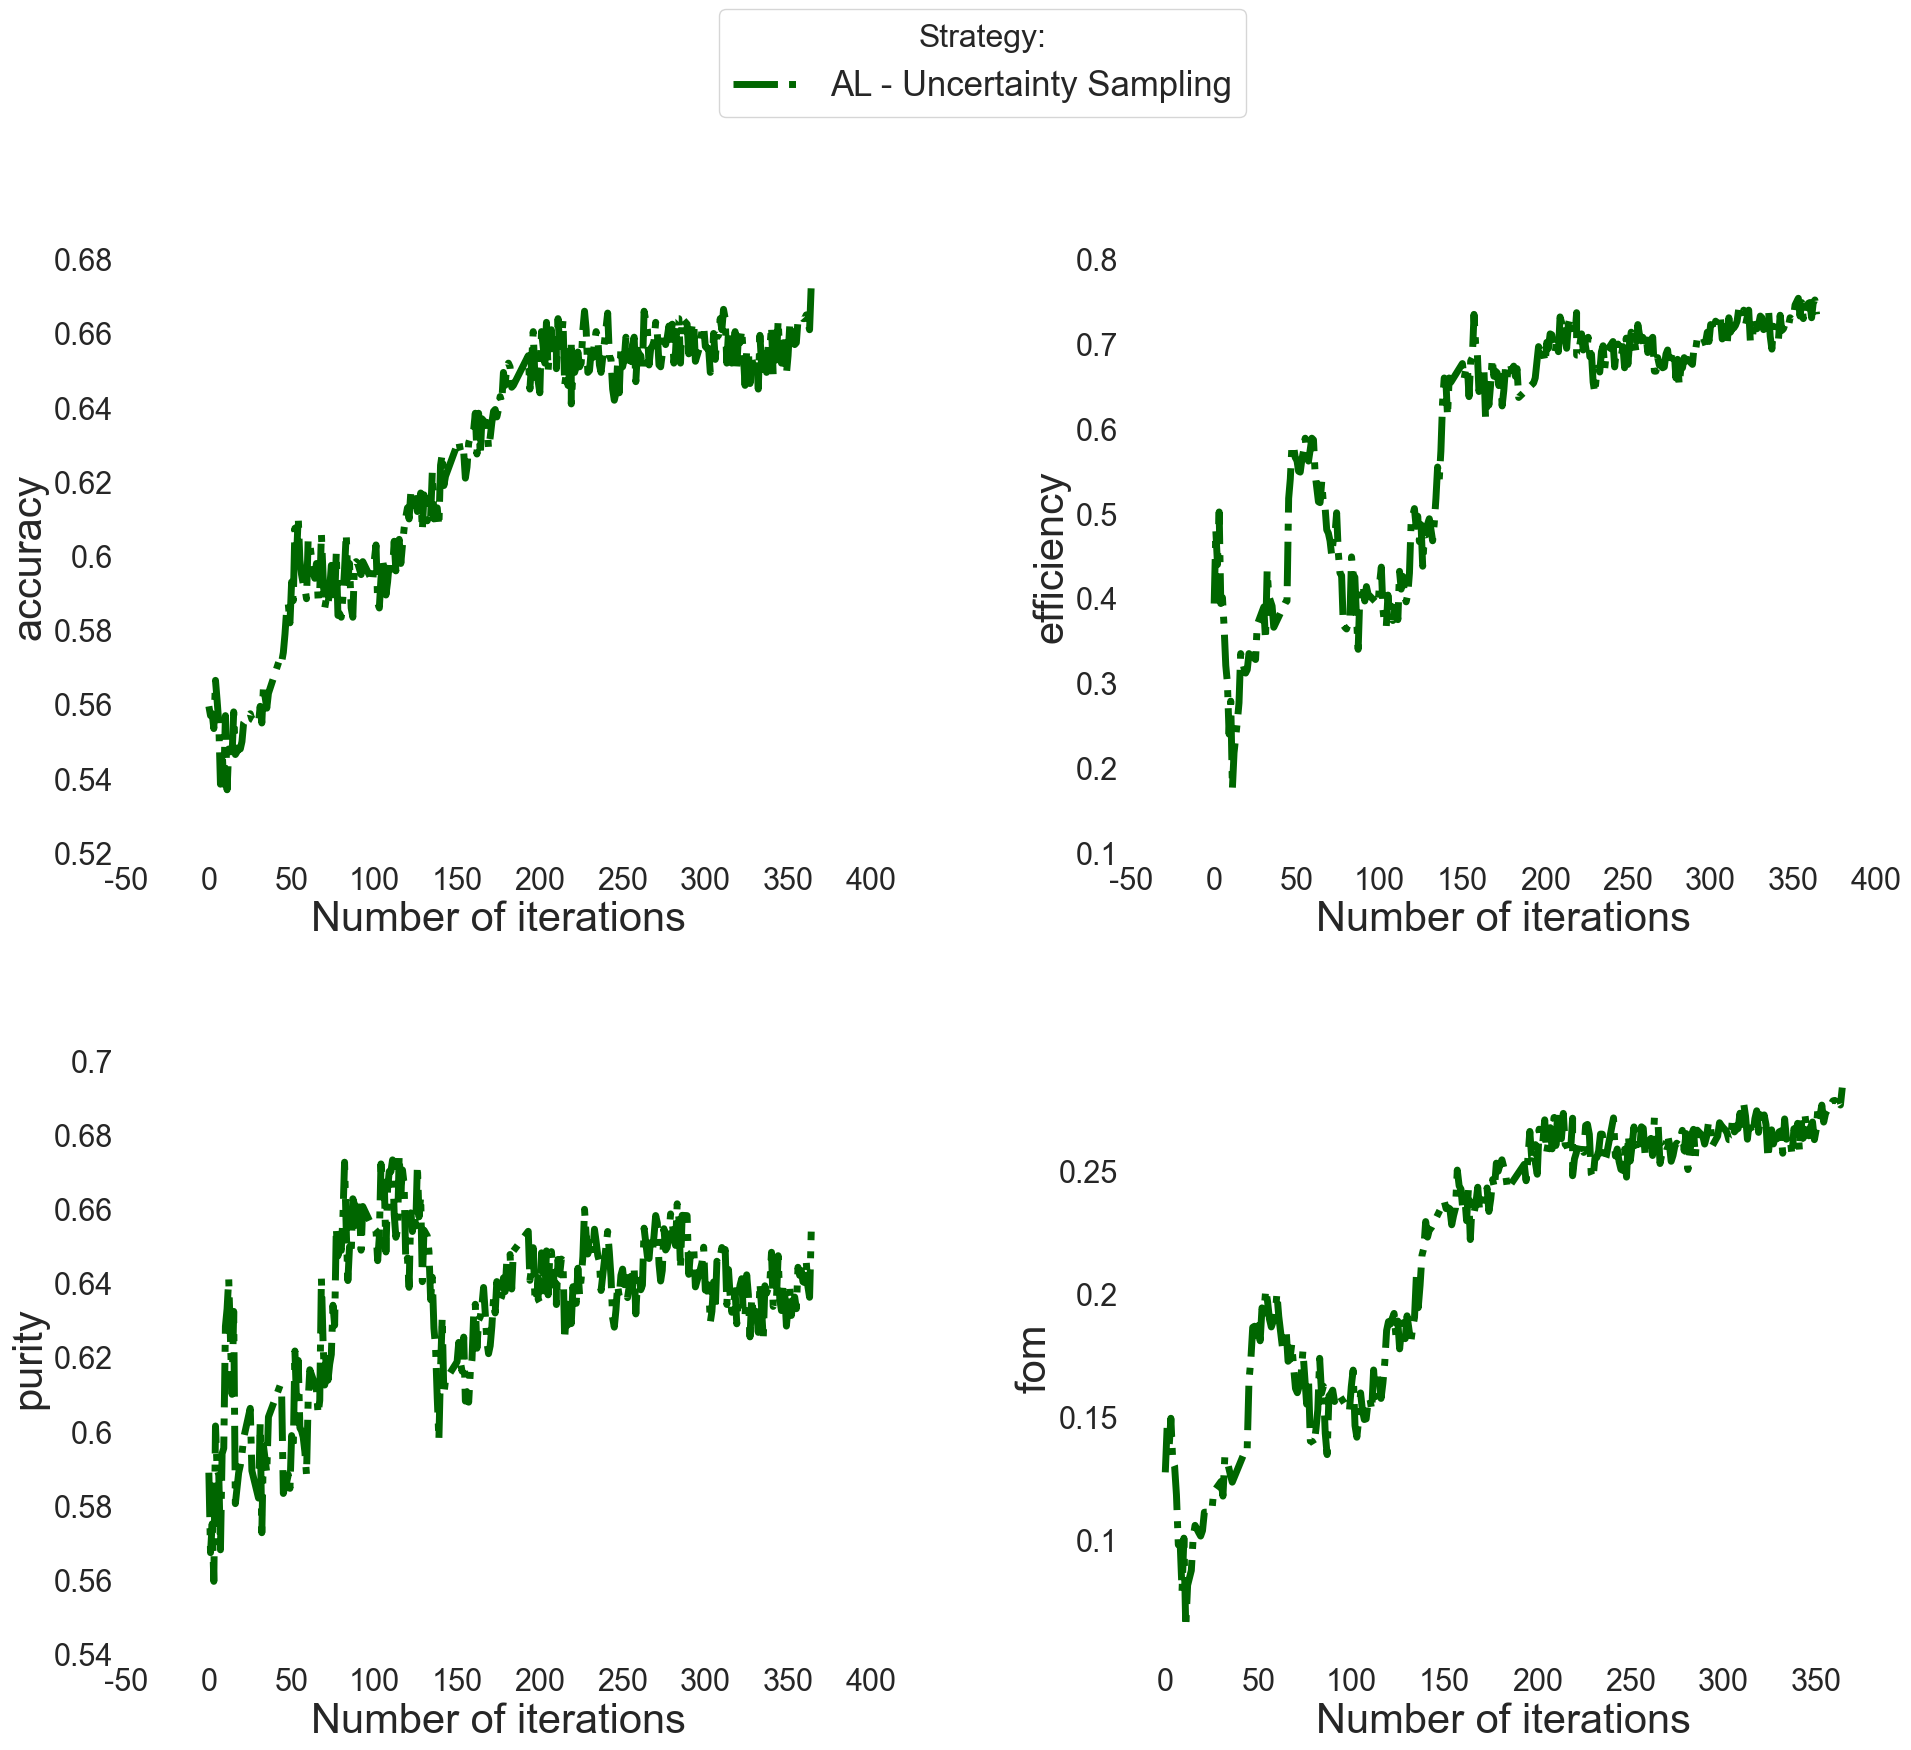

In [39]:
from resspect.plot_results import Canvas

# define parameters
path_to_files = ['results/metrics_UncSampling_ini_train_set_batch11.csv']#,
#                  'results/metrics_random.dat',
#                  'results/metrics_unc.dat']
strategies_list = ['UncSampling']
output_plot = 'plots/metrics.png'

#Initiate the Canvas object, read and plot the results for
# each metric and strategy.
cv = Canvas()
cv.load_metrics(path_to_files=path_to_files,
                   strategies_list=strategies_list)
cv.set_plot_dimensions()
cv.plot_metrics(output_plot_file=output_plot,
                   strategies_list=strategies_list)

# Testing for objects >100 days into survy

In [ ]:
def request_TOM_data(url: str = "https://desc-tom-2.lbl.gov", username: str = None, 
                     passwordfile: str = None, password: str = None, detected_since_mjd: float = None, 
                     detected_in_last_days: float = None, mjdnow: float = None, cheat_gentypes: list = None):
    tom = TomClient(url = url, username = username, passwordfile = passwordfile, 
                    password = password)
    dic = {}
    if detected_since_mjd is not None:
        dic['detected_since_mjd'] = detected_since_mjd
    if detected_in_last_days is not None:
        dic['detected_in_last_days'] = detected_in_last_days
    if mjdnow is not None:
        dic['mjd_now'] = mjdnow
    if cheat_gentypes is not None:
        dic['cheat_gentypes'] = cheat_gentypes
    res = tom.post('elasticc2/gethottransients', json = dic)
    print(res.text)
    #print(res)
    data_dic = res.json()
    return data_dic

In [ ]:
data_dic = request_TOM_data(url = "https://desc-tom-2.lbl.gov",username='amandaw8',
                                passwordfile='/Users/arw/secrets/tom2',detected_in_last_days = 1, mjdnow = 60997,
                                cheat_gentypes = [82, 10, 21, 27, 26, 37, 32, 36, 31, 89])
data_dic

# Below here I am testing for why TOM is only returning some reqs

In [ ]:
utc_now = datetime.now(timezone.utc)
time = str(utc_now).split('.')[0]

In [ ]:
ids = [1000052,
      1000065,
      1000111,
      1000154,
      1000155,
      1000168,
      1000283,
      1000294,
      1000296,
      1000344]
priorities = [1,1,2,2,3,3,4,4,5,5]
submit_queries_to_TOM('amandaw8', '/Users/arw/secrets/tom2', objectids = ids, priorities = priorities, requester = 'resspect')


      # 1000755
      # 1000859
      # 1000877
      # 1000899
      # 1000958
      # 1000990
      # 1001012
      # 1001013
      # 1001015
      # 1001039
      # 1001086

In [ ]:
username='amandaw8'
passwordfile='../../secrets/TOM2'
requested_since = time
tom = TomClient(url = "https://desc-tom-2.lbl.gov", username = username,
                    passwordfile = passwordfile)
dic = {}
if requested_since is not None:
    dic['requested_since'] = requested_since

dic['no_spectra_in_last_days']=0
res = tom.post( 'elasticc2/spectrawanted', json=dic )
assert res.status_code == 200
assert res.json()['status'] == "ok"
reqs = res.json()
print( reqs)

In [ ]:
reqs

In [ ]:
ids = get_ids(reqs)
ids

In [ ]:
id_list = []
Ia_type_list = []
sn_type_list = []
taxonomy_list = []
mjd_list = []
taxonomy_dic = {10:'2222', 
                30:'2224',31:'2224',32:'2224',35:'2224',36:'2224',37:'2224',
                20:'2223',21:'2223',25:'2223',26:'2223',27:'2223',
                82:'2233',
                89:'2235'}
for a_id in ids:
    # file = f'astrodash_spec_storage/Contaminated_RESSPECT/output_bank/DASH_matches_{a_id}.txt'
    try:
        sn_type = get_true_label(a_id,tom)#get_id_type_from_dash(file)
        if sn_type == 10:
            Ia_type = 'Ia'
        else:
            Ia_type = 'other'
        
        taxonomy_list.append(taxonomy_dic[sn_type])
        id_list.append(a_id)
        Ia_type_list.append(Ia_type)
        sn_type_list.append(sn_type)
        
        now = Time.now().mjd
        mjd_list.append(now)
    except:
        continue
print( id_list, Ia_type_list, sn_type_list, taxonomy_list, mjd_list)

In [ ]:
send_classes_to_TOM(id_list, mjd_list, taxonomy_list)

In [ ]:
id_list

In [2]:
!pwd

/Users/arw/RESSPECT/work_dir_true_label
